<a href="https://colab.research.google.com/github/digitalhumanitiestextbook/dhtextbook/blob/main/chapter07/7_dynamic_network_analysis_practice.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## 연습 데이터 준비 방법

- 연습문제를 실행하기 전에 **CSV 파일을 지정된 양식에 맞게 작성**해야 합니다.  
- **구텐베르크(Project Gutenberg)** 와 같은 공공 데이터베이스에서 텍스트 파일을 다운로드한 후, 제공된 **샘플 CSV 파일과 동일한 형식**으로 데이터를 정제하면 됩니다.  
- CSV 파일의 양식은 아래 코드 블록을 통해 확인할 수 있으며, 코드를 실행하면 **샘플 데이터**가 다운로드됩니다.  
- 파일을 다운로드하여 기존 내용을 삭제하고 형식에 맞게 데이터를 완성한 뒤, 두 번째 코드 블록을 실행하고 **"파일 선택" 버튼**을 눌러 작성한 CSV 파일을 업로드하면 됩니다.  

### CSV 파일의 컬럼 정보
- **quoteText**: 추출된 대화문 (type: `string`)  
- **timestamp**: 대화가 발생한 서사적 위치(챕터 단위) (type: `number`)  
- **speaker**: 발화자 (type: `string`)  
- **addressees**: 대상자 (type: `List<string>`)  

In [ ]:
import os
import requests
import pandas as pd
from google.colab import files

file_path = "quotation_info_sample.csv"
url = "https://github.com/digitalhumanitiestextbook/dhtextbook/raw/8acda2609d1d8d9141e52ea23e9fc4b9704d5fd1/chapter07/input/quotation_info_sample.csv"

# quotation_info_sample.csv 파일이 없으면 다운로드
if not os.path.exists(file_path):
    response = requests.get(url)
    response.raise_for_status()  # 오류 발생시 예외처리
    with open(file_path, "wb") as f:
        f.write(response.content)
    print(f"다운로드 완료: {file_path}")
else:
    print(f"이미 존재함: {file_path}")

files.download(file_path)
sample_data = pd.read_csv(file_path)
sample_data

- 아래 코드를 실행한 후 나타나는 "파일 선택" 버튼을 클릭하여, 완성한 CSV 파일을 업로드하세요.

In [ ]:
from google.colab import files
import os

# 파일 업로드
uploaded = files.upload()

# 업로드한 파일 경로 가져오기
file_path = list(uploaded.keys())[0]
root, ext = os.path.splitext(file_path)

# 데이터 수집 방법

In [ ]:
# 필요 라이브러리 설치 및 로드
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import ast

# NLTK 감정 분석기 다운로드
nltk.download('vader_lexicon')

# 데이터 로드
data = pd.read_csv(file_path)

# 단어 수 계산
data['word_count'] = data['quoteText'].astype(str).apply(lambda x: len(x.split()))

# VADER 감정 분석기 초기화
sia = SentimentIntensityAnalyzer()

# 감정 점수 계산 (Compound Score 사용)
data['sentiment'] = data['quoteText'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

# addressees 필드 문자열을 리스트로 변환
data['addressees'] = data['addressees'].apply(ast.literal_eval)

# 처리된 데이터 저장
processed_file_path = "processed_data.csv"
data.to_csv(processed_file_path, index=False)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hyeongraekim/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Google Colab 환경에서 생성된 CSV 파일을 로컬로 다운로드
from google.colab import files

files.download(processed_file_path)

# 노드와 에지 데이터 생성

In [ ]:
# 데이터 로드
data = pd.read_csv(processed_file_path)

# 'addressees' 컬럼이 문자열로 저장되어 있을 경우 리스트로 변환
if isinstance(data['addressees'][0], str):
    data['addressees'] = data['addressees'].apply(ast.literal_eval)

# 노드 생성: 등장인물 목록 추출
all_characters = set(data['speaker'].unique())  # 발화자로 등장한 인물
for addressees in data['addressees']:
    all_characters.update(addressees)  # 대상자로 등장한 인물도 추가

# 노드 속성 생성 (대화량, 감정 점수 평균)
nodes_data = pd.DataFrame({'node_name': list(all_characters)})

# 발화자 기준 대화량 합산
nodes_data['total_word_count'] = nodes_data['node_name'].apply(
    lambda x: data[data['speaker'] == x]['word_count'].sum() if x in data['speaker'].values else 0
)

# 발화자 기준 감정 점수 평균
nodes_data['average_sentiment'] = nodes_data['node_name'].apply(
    lambda x: data[data['speaker'] == x]['sentiment'].mean() if x in data['speaker'].values else 0
)

# 에지 생성 (발화자-대상자 관계)
edge_list = []
for _, row in data.iterrows():
    speaker = row['speaker'] # 발화자
    word_count = row['word_count'] # 단어 수
    sentiment = row['sentiment'] # 감정 점수
    addressees = row['addressees'] # 대상자 (리스트 형태)

    # 대상자가 여러 명일 경우 개별적으로 저장
    for target in addressees:
        edge_list.append({'source': speaker, 'target': target, 'word_count': word_count, 'sentiment': sentiment})

# 에지 데이터프레임 생성
edges_data = pd.DataFrame(edge_list)

# 파일 저장
nodes_data.to_csv("nodes.csv", index=False)
edges_data.to_csv("edges.csv", index=False)

In [ ]:
# Google Colab 환경에서 생성된 CSV 파일을 로컬로 다운로드
files.download("nodes.csv")
files.download("edges.csv")

# 시간정보 추가

In [ ]:
# 시간 정보가 포함된 에지 데이터 생성
edge_list_time = []
for _, row in data.iterrows():
    speaker = row['speaker'] # 발화자
    word_count = row['word_count'] # 단어 수
    sentiment = row['sentiment'] # 감정 점수
    timestamp = row['Timestamp']  # 대화 발생 시점

    for target in row['addressees']:
        edge_list_time.append({'source': speaker, 'target': target,
                               'word_count': word_count, 'sentiment': sentiment,
                               'timestamp': timestamp})

# 데이터프레임 변환 및 저장
edge_time_data = pd.DataFrame(edge_list_time)
edge_time_data.to_csv("edges_with_time.csv", index=False)

In [ ]:
# Google Colab 환경에서 생성된 CSV 파일을 로컬로 다운로드
files.download("edges_with_time.csv")

# 연결망 분석 수행 및 시각화

### 1. 그래프 기본 속성 설정

In [14]:
# 네트워크 분석을 위한 라이브러리 로드
import networkx as nx

# 고정된 주요 노드 위치 설정
fixed_positions = {
    'Mr. Darcy': (-0.2, 0),
    'Elizabeth': (0.2, 0)
}

# 노드 속성 설정
G = nx.DiGraph()

# 노드 추가 및 속성 설정
for _, row in nodes_data.iterrows():
    G.add_node(row['node_name'], size=row['total_word_count'], sentiment=row['average_sentiment'])

# 에지 추가 및 속성 설정
for _, row in edge_time_data.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['word_count'], sentiment=row['sentiment'])

# 중심성 계산
centrality = nx.degree_centrality(G)

# 노드 크기 설정 (중심성에 따라 크기 조정)
node_sizes = {node: 1000 + 5000 * centrality.get(node, 0) for node in G.nodes}

### 2. 그래프 제작 함수 정의

In [15]:
import matplotlib.pyplot as plt

# 색상 단계 정의 (9단계의 색상 반환)
def get_color(sentiment):
    bins = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
    colors = ['#800000', '#B22222', '#DC143C', '#FF6347', '#FFD700',
              '#ADFF2F', '#7FFF00', '#32CD32', '#006400']
    for i in range(len(bins) - 1):
        if bins[i] <= sentiment < bins[i + 1]:
            return colors[i]
    return '#808080'  # Default to gray

# 레이아웃 설정 함수
# 고정된 노드 위치를 유지하면서 나머지 노드에 대해 spring_layout 적용
def get_layout(graph, node_sizes, fixed_positions=None):
    if fixed_positions is None:
        fixed_positions = {}

    # 고정되지 않은 노드에 대해 spring_layout 적용
    free_nodes = [node for node in graph.nodes if node not in fixed_positions]
    free_layout = nx.spring_layout(graph.subgraph(free_nodes), seed=42, k=3 / len(graph.nodes) ** 0.5)

    # 고정된 노드 병합
    layout = {**free_layout, **fixed_positions}

    # 노드 크기 반영 위치 조정
    for node, (x, y) in layout.items():
        layout[node] = (x * (1 + node_sizes.get(node, 1000) / 10000), y * (1 + node_sizes.get(node, 1000) / 10000))

    return layout

# 그래프 그리기 함수
# 주어진 타임스탬프에 따라 그래프를 갱신
def draw_graph(edges_at_timestamp, title):
    # 그래프 초기화
    plt.cla()

    # 새로운 그래프 생성
    G_frame = nx.DiGraph()

    # 노드 크기와 색상 설정
    for node in G.nodes:
        G_frame.add_node(node, size=node_sizes.get(node, 1000), color='gray')

    # 에지 추가 및 노드 색상 갱신
    for _, row in edges_at_timestamp.iterrows():
        # 에지 정보 추출
        source = row['source']
        target = row['target']
        weight = row['word_count']
        sentiment = row['sentiment']

        # 노드 색상 갱신
        if source in G_frame.nodes:
            G_frame.nodes[source]['color'] = get_color(sentiment)
        if target in G_frame.nodes:
            G_frame.nodes[target]['color'] = get_color(sentiment)

        # 에지 추가
        G_frame.add_edge(source, target, weight=weight)

    # 레이아웃 설정
    dynamic_pos = get_layout(G_frame, node_sizes, fixed_positions)

    node_colors = [G_frame.nodes[node]['color'] for node in G_frame.nodes]  # 노드 색상 설정
    node_sizes_list = [G_frame.nodes[node]['size'] for node in G_frame.nodes]  # 노드 크기 설정
    edge_widths = [min(5, max(0.5, G_frame[u][v]['weight'] / 10)) for u, v in G_frame.edges]  # 에지 width 설정

    # 그래프 그리기
    nx.draw(
        G_frame, dynamic_pos, with_labels=True, node_color=node_colors, node_size=node_sizes_list,
        edge_color='black', width=edge_widths, font_size=10
    )
    # 그래프 제목 설정
    plt.title(title)



### 3. 애니메이션 생성

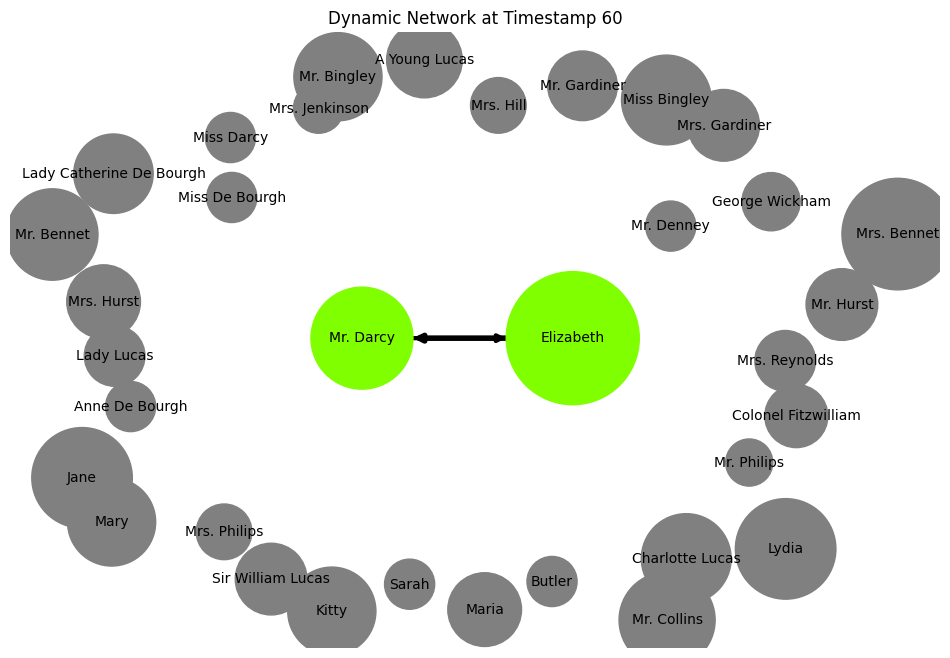

In [ ]:

from matplotlib.animation import FuncAnimation

# 동적 연결망 갱신 함수 (주어진 타임스탬프에 따라 그래프를 갱신)
def update_graph(frame):
    timestamp = timestamps[frame] # 현재 타임스탬프 선택
    edges_at_timestamp = edge_time_data[edge_time_data['timestamp'] == timestamp] # 타임스탬프에 해당하는 에지만 선택
    draw_graph(edges_at_timestamp, f"Dynamic Network at Timestamp {timestamp}")  # 그래프 그리기

# 타임스탬프 기준으로 정렬
timestamps = sorted(edge_time_data['timestamp'].unique())

# 애니메이션 생성
fig = plt.figure(figsize=(12, 8))
anim = FuncAnimation(fig, update_graph, frames=len(timestamps), interval=500)

# 애니메이션 저장
anim.save('dynamic_network.mp4', writer='ffmpeg')

# 최종 결과 표시
plt.show()

In [ ]:
# Google Colab 환경에서 생성된 MP4 파일을 로컬로 다운로드
files.download("dynamic_network.mp4")

### 4. 스냅샷 그래프 파일 다운로드

In [ ]:
import os
import shutil
from zipfile import ZipFile

# 저장할 임시 디렉터리 생성
output_dir = "network_frames"
os.makedirs(output_dir, exist_ok=True)

# 모든 타임스탬프별 그래프를 PNG로 저장
for frame, timestamp in enumerate(timestamps):
    # 타임스탬프에 해당하는 에지 데이터 선택
    edges_at_timestamp = edge_time_data[edge_time_data['timestamp'] == timestamp]

    # 새로운 그래프 생성
    plt.figure(figsize=(12, 8)) 

    # 그래프 그리기
    draw_graph(edges_at_timestamp, f"Dynamic Network at Timestamp {timestamp}")

    # 파일 저장
    filename = os.path.join(output_dir, f"network_{frame:03d}.png")

    # 그래프 저장
    plt.savefig(filename)
    plt.close()

# ZIP 파일로 압축
zip_filepath = "network_frames.zip"
with ZipFile(zip_filepath, 'w') as zipf:
    for file in os.listdir(output_dir):
        zipf.write(os.path.join(output_dir, file), arcname=file)

# 임시 디렉터리 삭제
shutil.rmtree(output_dir)

In [ ]:
# Google Colab 환경에서 생성된 ZIP 파일을 로컬로 다운로드
files.download(zip_filepath)